## Phasing of single diffraction pattern (Fig. 11)

In [1]:
# Import modules
import sys, h5py
import numpy as np
import scipy.ndimage as ndimage
import spimage
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
plotdir = '/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/'

In [3]:
# Configuration (Experiment)
distance_back  = 2.4 #[m]
distance_front = 0.497 #[m]
pixelsize = 110e-6 #[m]
wavelength = 0.2262e-9 #[m]
downsampling = 4

In [4]:
# Convert index to q (in nm)
x_to_q = lambda x, d: (2*np.sin(np.arctan2(x*pixelsize*downsampling, d)/2.)) / wavelength / 1e9

### 1. Loading data from file

In [5]:
# Loading the phased reconstruction
filename = "../meta/phasing.h5"
with h5py.File(filename, 'r') as f:
    recons  = f['real_space_final'][:]
    fourier = f['fourier_space_final'][:]
    support = f['support_final'][:]
    rerror  = f["real_error"][:]
    ferror  = f["fourier_error"][:]

In [6]:
# Pixelsize in real space
dx = wavelength * distance_front / (fourier.shape[1] * pixelsize*downsampling) #[m/px]
print "One pixel in real space corresponds to %.1f nm" %(dx*1e9)

One pixel in real space corresponds to 2.0 nm


### 2. Validation using PRTF

In [9]:
# Calculate PRTF
output_prtf = spimage.prtf(recons, support, enantio=True, translate=True)

# Collect PRTF results
superimage = output_prtf['super_image']
prtf_2d    = output_prtf['prtf']

# Radial average of PRTF
nx, ny = prtf_2d.shape[1], prtf_2d.shape[0]
xx,yy = np.meshgrid(np.arange(nx),np.arange(ny))
mask_radial = np.sqrt((xx-nx/2)**2 + (yy-ny/2)**2) < nx/2
prtf_centers, prtf_radial = spimage.radialMeanImage(prtf_2d, msk=mask_radial, output_r=True)
prtf_qr = x_to_q(prtf_centers, distance_front)
limit_qr = prtf_qr[np.abs(ndimage.gaussian_filter1d(prtf_radial,2) - (1/np.e)).argmin()]

### 3. Plotting

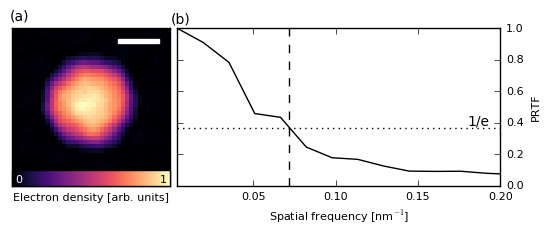

The PRTF drops below 1/e at a resolution of 13.45 nm


In [12]:
plot = plotting.Plot(fontsize=8, rows=1, cols=3, legend=True, legend_frameon=False, exclude=(1,2), save_pdf=True)
plot.add_axes((1,0),2,1, padx=0)
plot.add_axes((0,0),1,1, hfrac=0.1)
plot.xlabel = ['', r'Spatial frequency [nm$^{-1}$]']
plot.ylabel = ['', 'PRTF']
plot.title_label = 2*['']

plot.plotting_a_map(0, np.abs(superimage)[46:-44,45:-45], cmap='magma', 
                    colorbar=True, cax=plot.axes[2], colorbar_orientation='horizontal')
plot.axes[0].set_xticks([])
plot.axes[0].set_xticklabels([])
plot.axes[0].set_yticks([])
plot.axes[0].set_yticklabels([])
plot.plotting_a_rectangle(0, 25, 2, 20./(1e9*dx), 1, facecolor='w', edgecolor='w')
plot.axes[0].text(-1, -5, '(a)', va='top', ha='left', fontsize=10)

plot.plotting_traces(1, [prtf_qr[:-5][::4]], 
                     [prtf_radial[:-5].reshape((15,4)).mean(axis=1)], 
                     [''], ylim=[0,1],xlim=[prtf_qr[0],0.2],
                     linestyles=['-'], linewidths=[1], markers=[None],
                     mecs=['k'], mfcs=['k'], colors=['k'])
plot.axes[1].axhline(1/np.e, ls=':', color='k')
plot.axes[1].axvline(1/14., color='k', ls='--')
plot.axes[1].tick_params(labelright='on', labelleft='off')
plot.axes[1].yaxis.set_label_position('right')
plot.axes[1].text(0, 1.1, '(b)', va='top', ha='left', fontsize=10)
plot.axes[1].text(0.18, 1/np.e, '1/e', va='bottom')

plot.axes[2].set_ylabel('')
plot.axes[2].set_xlabel(r'Electron density [arb. units]', fontsize=8)
plot.axes[2].tick_params(axis='x', which='both', top='off', bottom='off', labeltop='off', labelbottom='off')
plot.axes[2].text(0.02,0.4, '0', color='w', va='center', ha='left', fontsize=8)
plot.axes[2].text(0.98,0.4, '1', color='k', va='center', ha='right', fontsize=8)

#plot.save(plotdir + 'fig_phasing.pdf')
plot.show()
print "The PRTF drops below 1/e at a resolution of %.2f nm" %(1./limit_qr)

**Figure 11.**
Image reconstruction based on an individual diffraction pattern of a sample-sized object.                                       
(a) Average magnitude based on $5000$ independent reconstructions. The scale bar indicates 20 nm.                                                                                  
(b) Phase retrieval transfer function (PRTF) dropping below 1/e (dotted line) at a resolution of $13.5$ nm (dashed line).